# Group Assignment #4
### Author: Gema Martinez

## Who’s Most at Risk? Social Demographics and Traffic Collisions in the City of Los Angeles
This notebook examines the Spatial Autocorrelation Analysis of fatalities (bike and pedestrians) in the City of Los Angeles from 2015-2019 using UC Berkeley's Transportation Injury Mapping System (TIMS) data.

## Data Sources & Geographic Information
2019 Census Tracts from IPUMS NHGIS (At the time, we could not download the TIGER/Shapefile due to federal government actions).

2015 - 2019 UC Berkeley - TIMS

In [2]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# importing census tracts
la_tracts = gpd.read_file('Data/cityLA.zip')

In [4]:
# our zip file does not include total population needed for future analysis 
# upload acs 2015-2019 data 
income = pd.read_csv('Data/R13808337_SL140.csv')

In [5]:
#converting FIPS, STATE, and COUNTY from integer to string & reintegrate leading zero
income = pd.read_csv(
    'Data/R13808337_SL140.csv',
    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str
    }
)

In [6]:
#refining data to keep only necessary columns
columns_to_keep = ['Geo_FIPS', 
                   'Geo_STATE', 
                   'Geo_COUNTY',
                   'SE_A14006_001']

income = income[columns_to_keep]

In [7]:
#remnaing columns
income.columns = ['FIPS',
                'State',
                'County',
                'Median Income']

In [8]:
#importing total population csv from ACS 2015-2019 to include in median income dataframe
total_population = pd.read_csv('Data/Total Population.csv')

In [9]:
#converting FIPS, STATE, and COUNTY from integer to string & reintegrate leading zero
total_population = pd.read_csv(
    'Data/Total Population.csv',
    dtype=
    {
        'Geo_FIPS':str,
        'Geo_STATE':str,
        'Geo_COUNTY': str,
        'SE_A00001_001': str
    }
)

In [10]:
#cleaning total pop data
columns_to_keep_pop = ['Geo_FIPS', 
                   'Geo_STATE', 
                   'Geo_COUNTY',
                   'SE_A00001_001']

total_population = total_population[columns_to_keep_pop]

In [11]:
#renaming columns
total_population.columns = ['FIPS',
                'State',
                'County',
                'Total Population']

In [12]:
#checking dataframe
total_population.head(2)

FIPS State County Total Population
0  06037101110    06    037             4283
1  06037101122    06    037             3405

In [13]:
#merging income and total population
income_pop = income.merge(total_population, on="FIPS")

In [14]:
#checking that both dataframes merged together
income_pop.head(2)

FIPS State_x County_x  Median Income State_y County_y  \
0  06037101110      06      037        63534.0      06      037   
1  06037101122      06      037        90389.0      06      037   

  Total Population  
0             4283  
1             3405

In [15]:
# creating new FIPS column to prepare census tracts dataframe for mergining
la_tracts['FIPS'] = '06' + '037' + la_tracts['TRACTCE']

In [16]:
# merging census tracts and total population 
la_city = la_tracts.merge(total_population, on="FIPS")

In [17]:
#checking that data merged
la_city.head(2)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
0  G0600370101110      06      037  101110  06037101110  1011.10   
1  G0600370101122      06      037  101122  06037101122  1011.22   

               NAMELSAD  MTFCC FUNCSTAT      ALAND  ...     INTPTLAT  \
0  Census Tract 1011.10  G5020        S  1142401.0  ...  +34.2594737   
1  Census Tract 1011.22  G5020        S  2644045.0  ...  +34.2677213   

       INTPTLON   Shape_Leng   Shape_Le_1    Shape_Area  \
0  -118.2929869  4585.520052  4585.520052  1.142400e+06   
1  -118.2901465  9652.233049  9652.233049  2.644046e+06   

                                            geometry         FIPS State  \
0  POLYGON ((-2019033.589 -124429.155, -2018948.5...  06037101110    06   
1  POLYGON ((-2017297.948 -125225.326, -2017305.0...  06037101122    06   

  County Total Population  
0    037             4283  
1    037             3405  

[2 rows x 21 columns]

In [18]:
#cleaning the data to only include necessary columns 
columns_to_keep_la = ['FIPS', 
                   'Total Population', 
                   'geometry']

la_city = la_city[columns_to_keep_la]

In [19]:
# identifying total population row to delete; there is no total population column 
la_city.tail()

FIPS Total Population  \
1163  06037980026               26   
1164  06037980028                0   
1165  06037980030                0   
1166  06037980031             1175   
1167  06037980033               16   

                                               geometry  
1163  POLYGON ((-2017734.652 -121289.969, -2017604.1...  
1164  POLYGON ((-2037371.498 -155528.944, -2037368.6...  
1165  POLYGON ((-2039470.503 -159401.276, -2039585.4...  
1166  MULTIPOLYGON (((-2027306.945 -179844.798, -202...  
1167  MULTIPOLYGON (((-2027800.331 -180973.621, -202...

In [20]:
# modifuing total population to numerical values to fix sorting issue (the column was not sorting)
la_city['Total Population'] = pd.to_numeric(la_city['Total Population'], errors='coerce')
la_city.sort_values(by='Total Population', ascending=True).head(20)

FIPS  Total Population  \
1165  06037980030                 0   
1164  06037980028                 0   
1008  06037320000                 0   
1149  06037980002                 0   
1158  06037980020                 0   
1160  06037980022                 0   
1161  06037980023                 0   
1154  06037980013                 0   
1150  06037980005                 0   
1148  06037980001                 0   
1152  06037980009                 5   
1155  06037980014                 9   
1167  06037980033                16   
1163  06037980026                26   
1159  06037980021                33   
1032  06037532400                45   
1151  06037980008                68   
1146  06037930101                90   
1065  06037575500                93   
1153  06037980010                95   

                                               geometry  
1165  POLYGON ((-2039470.503 -159401.276, -2039585.4...  
1164  POLYGON ((-2037371.498 -155528.944, -2037368.6...  
1008  MULTIPOLYGON (((-2026987.276 -137679.181, -202...  
1149  MULTIPOLYGON (((-2025190.604 -177036.987, -202...  
1158  POLYGON ((-2019136.183 -127669.077, -2019102.7...  
1160  POLYGON ((-2034697.534 -114703.299, -2034687.1...  
1161  POLYGON ((-2047272.84 -120824.771, -2047312.73...  
1154  MULTIPOLYGON (((-2034925.473 -159035.208, -203...  
1150  POLYGON ((-2030557.304 -168200.728, -2030641.3...  
1148  MULTIPOLYGON (((-2026441.139 -130545.925, -202...  
1152  POLYGON ((-2022567.042 -135317.48, -2022521.63...  
1155  POLYGON ((-2023897.332 -173566.566, -2023897.0...  
1167  MULTIPOLYGON (((-2027800.331 -180973.621, -202...  
1163  POLYGON ((-2017734.652 -121289.969, -2017604.1...  
1159  POLYGON ((-2025428.836 -121670.065, -2025123.7...  
1032  MULTIPOLYGON (((-2016109.903 -153887.653, -201...  
1151  POLYGON ((-2037999.512 -124659.921, -2037596.7...  
1146  MULTIPOLYGON (((-2013586.944 -124850.593, -201...  
1065  MULTIPOLYGON (((-2024641.672 -178266.284, -202...  
1153  POLYGON ((-2018570.594 -143801.843, -2018563.2...

In [21]:
# deleting entries where the total population is less than 100
la_city = la_city[la_city['Total Population']>100]

In [22]:
# upload crash data 
# use pandas since we do not have geometry data 
ped = pd.read_csv('Data/Ped Crashes TIMS.csv')

In [23]:
# convert data to geodataframe to plot 
ped = gpd.GeoDataFrame(ped, 
                         crs ='EPSG:4326', 
                         geometry=gpd.points_from_xy(ped.POINT_X, ped.POINT_Y))

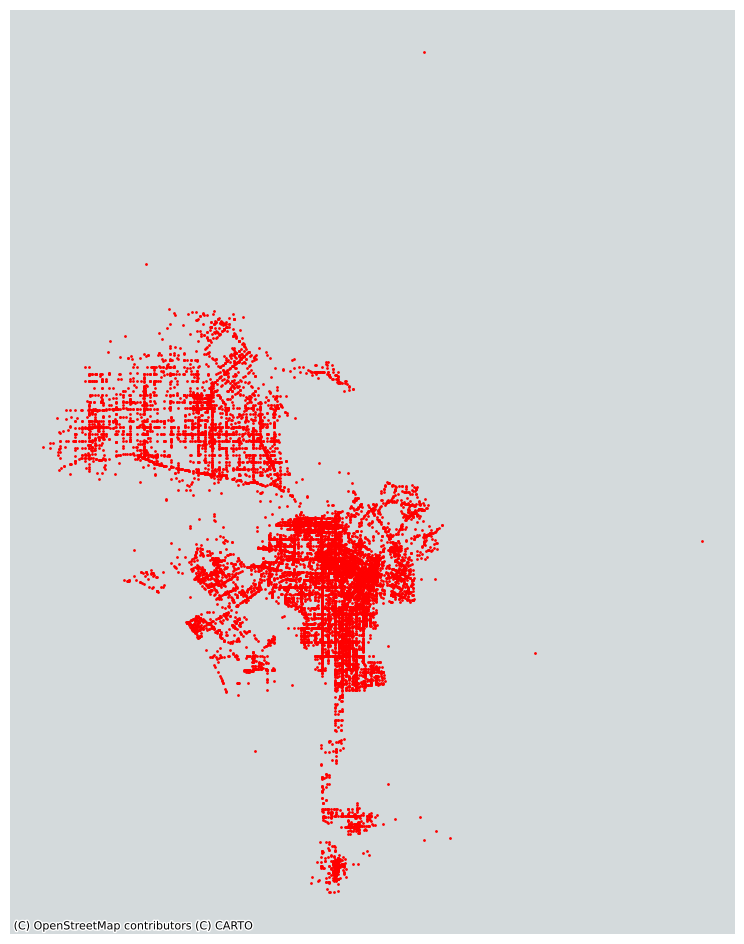

In [24]:
# map crash data
fig,ax = plt.subplots(figsize=(12,12))

ped.plot(ax=ax,
             color='red',
             markersize=1)

ax.axis('off')

ctx.add_basemap(ax,zoom=12, source=ctx.providers.CartoDB.Positron)

In [25]:
# calculating the bounds for crash data 
# purpose - we want to zoom into the crash layer and NOT census tracts 
minx, miny, maxx, maxy = ped.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-118.66452026367188
-117.82411956787108
33.71059011
34.59749005


In [26]:
#joining census tracrts and pedestrian collisions
ped = ped.to_crs(epsg=3857)
la_city = la_city.to_crs(epsg=3857)
join = gpd.sjoin(la_city, ped, how='left')

In [27]:
join.head(5)

FIPS  Total Population  \
0  06037101110              4283   
0  06037101110              4283   
0  06037101110              4283   
0  06037101110              4283   
0  06037101110              4283   

                                            geometry  index_right    CASE_ID  \
0  POLYGON ((-13168864.246 4064201.311, -13168757...      12584.0  8703203.0   
0  POLYGON ((-13168864.246 4064201.311, -13168757...       2121.0  7175207.0   
0  POLYGON ((-13168864.246 4064201.311, -13168757...        402.0  8148117.0   
0  POLYGON ((-13168864.246 4064201.311, -13168757...      15527.0  8969842.0   
0  POLYGON ((-13168864.246 4064201.311, -13168757...       4685.0  8016768.0   

   ACCIDENT_YEAR   PROC_DATE   JURIS COLLISION_DATE  COLLISION_TIME  ...  \
0         2018.0  2018-10-12  1942.0     2018-09-25          1810.0  ...   
0         2016.0  2016-02-04  1942.0     2016-01-04          1435.0  ...   
0         2016.0  2016-10-18  1942.0     2016-09-16           755.0  ...   
0         2019.0  2019-11-22  1942.0     2019-10-25           745.0  ...   
0         2016.0  2016-04-12  1942.0     2016-03-26          1835.0  ...   

  COUNT_MC_KILLED COUNT_MC_INJURED  PRIMARY_RAMP  SECONDARY_RAMP  LATITUDE  \
0             0.0              0.0            -               -        NaN   
0             0.0              0.0            -               -        NaN   
0             0.0              0.0            -               -        NaN   
0             0.0              0.0            -               -        NaN   
0             0.0              0.0            -               -        NaN   

   LONGITUDE       COUNTY         CITY     POINT_X    POINT_Y  
0        NaN  LOS ANGELES  LOS ANGELES -118.291054  34.255939  
0        NaN  LOS ANGELES  LOS ANGELES -118.291050  34.255940  
0        NaN  LOS ANGELES  LOS ANGELES -118.291050  34.255940  
0        NaN  LOS ANGELES  LOS ANGELES -118.291328  34.256691  
0        NaN  LOS ANGELES  LOS ANGELES -118.288663  34.255920  

[5 rows x 84 columns]

In [28]:
# creating new dataframe for ped collision by census tract
crash_by_cs = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='Pedestrian Collision Count')
crash_by_cs

FIPS  Pedestrian Collision Count
0     06037226002                         196
1     06037207710                         148
2     06037206300                         105
3     06037206200                          96
4     06037296600                          96
...           ...                         ...
1143  06037600100                           1
1144  06037600201                           1
1145  06037980019                           1
1146  06037102104                           1
1147  06037102105                           1

[1148 rows x 2 columns]

In [29]:
# descriptive stats for pedestian collisions. On average each census tract has had 18 pedestrian collision.
crash_by_cs['Pedestrian Collision Count'].describe()

count    1148.000000
mean       13.452091
std        14.358966
min         1.000000
25%         4.000000
50%        10.000000
75%        18.000000
max       196.000000
Name: Pedestrian Collision Count, dtype: float64

In [30]:
# merging census tracts with pedestrian collisions 
la_city=la_city.merge(crash_by_cs,on='FIPS')

In [31]:
# verifying that both dataframes merged together
la_city.head(10)


FIPS  Total Population  \
0  06037101110              4283   
1  06037101122              3405   
2  06037101210              6347   
3  06037101220              3702   
4  06037101300              3884   
5  06037101400              3458   
6  06037102103              1763   
7  06037102104              3721   
8  06037102105              1905   
9  06037102107              4349   

                                            geometry  \
0  POLYGON ((-13168864.246 4064201.311, -13168757...   
1  POLYGON ((-13166582.527 4063754.258, -13166586...   
2  POLYGON ((-13167528.967 4063214.44, -13167528....   
3  POLYGON ((-13167423.881 4063213.632, -13167369...   
4  POLYGON ((-13165229.103 4062741.029, -13165229...   
5  POLYGON ((-13169034.788 4063225.626, -13168864...   
6  POLYGON ((-13173921.826 4059171.99, -13173936....   
7  POLYGON ((-13173332.61 4058687.307, -13173367....   
8  POLYGON ((-13173883.427 4056571.41, -13173900....   
9  POLYGON ((-13172435.269 4063723.845, -13172429...   

   Pedestrian Collision Count  
0                           8  
1                           3  
2                          13  
3                           4  
4                           6  
5                           6  
6                           6  
7                           1  
8                           1  
9                           7

In [32]:
# new column "killed_per_1000" - the crash/killed rate 
la_city['collision_per_1000'] = la_city['Pedestrian Collision Count']/la_city['Total Population']*1000

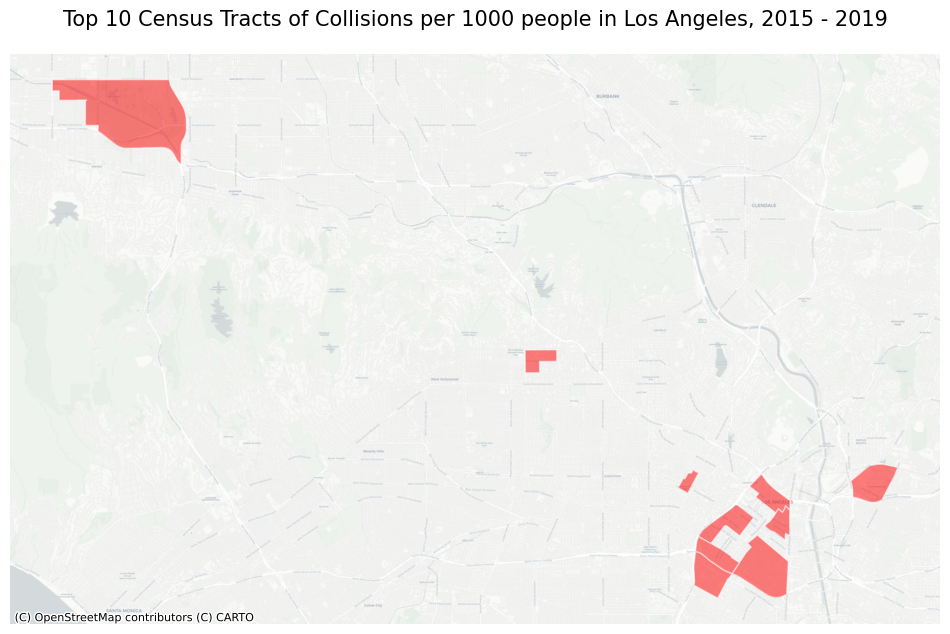

In [33]:
# seeing the location of the top 10 places folks are killed 
fig,ax = plt.subplots(figsize=(12,12))
la_city.sort_values(by='collision_per_1000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5)


# title
ax.set_title('Top 10 Census Tracts of Collisions per 1000 people in Los Angeles, 2015 - 2019',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax, zoom=14, source=ctx.providers.CartoDB.Positron)

<Axes: ylabel='Frequency'>

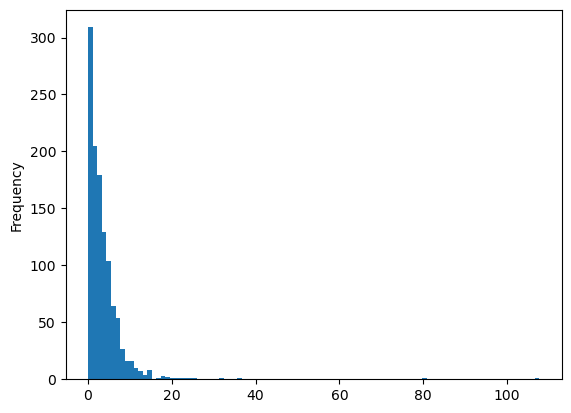

In [34]:
# identifying skew to determine mapping approach
la_city['collision_per_1000'].plot.hist(bins=100)

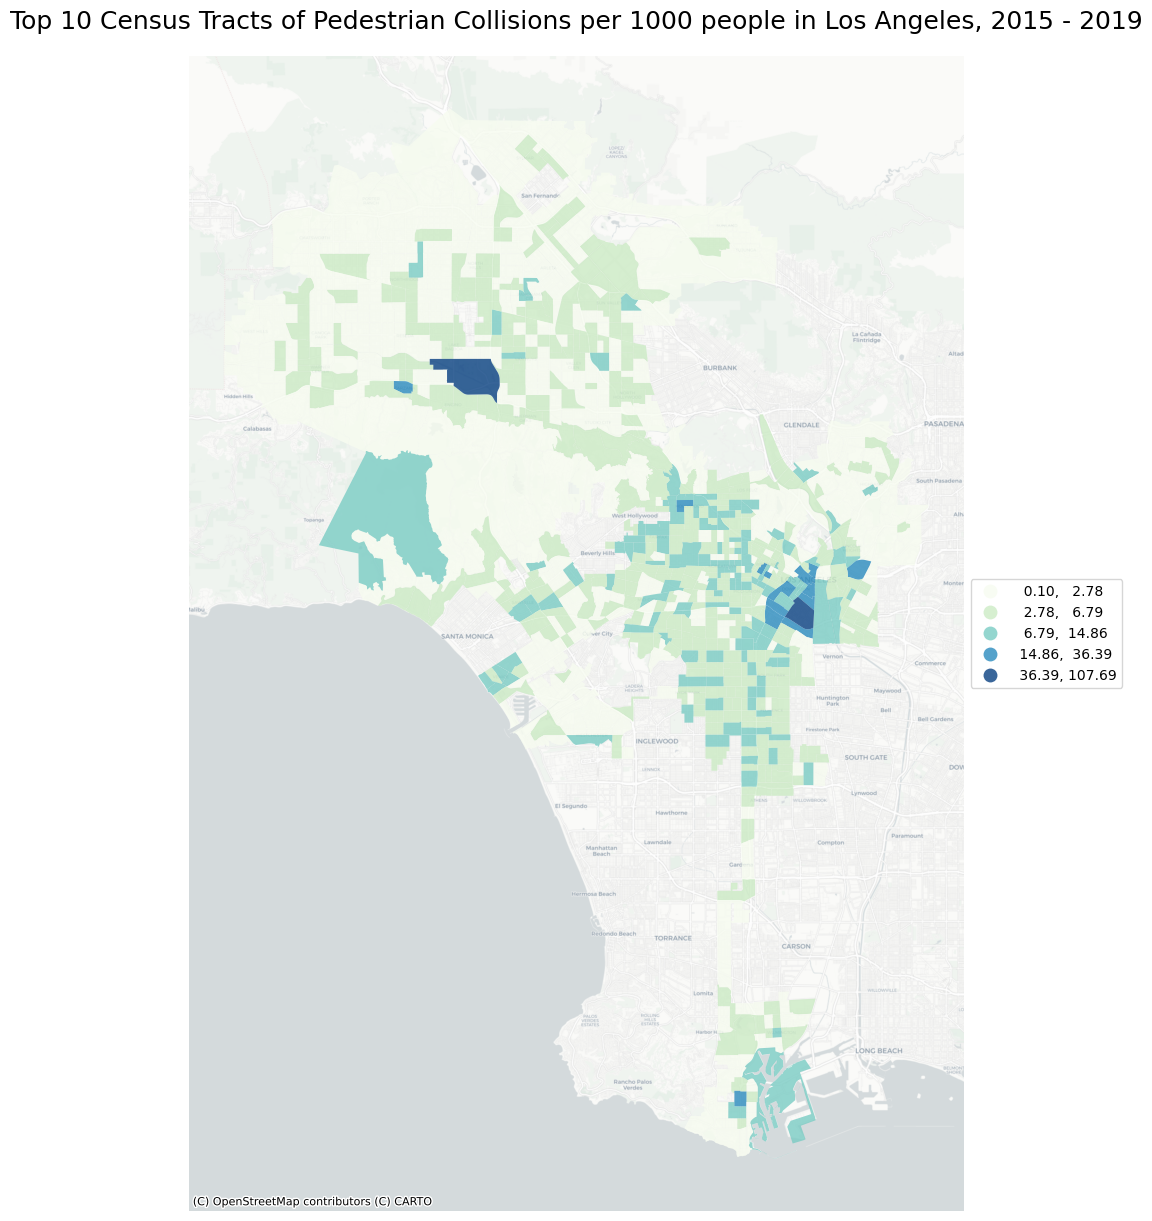

In [35]:
# using natural breaks for choropleth map 
fig,ax = plt.subplots(figsize=(15,15))

la_city.plot(ax=ax,  
        column='collision_per_1000',
        legend=True,
        alpha=0.8,    
        cmap='GnBu', 
        scheme='naturalbreaks',
        legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})

ax.axis('off')
ax.set_title('Top 10 Census Tracts of Pedestrian Collisions per 1000 people in Los Angeles, 2015 - 2019',fontsize=18,pad=20)
ctx.add_basemap(ax, zoom= 12,source=ctx.providers.CartoDB.Positron)

In [36]:
# creating interactive map of the same data presented above
la_city.explore(column='collision_per_1000', 
        legend=True,
        cmap='GnBu', 
        scheme='naturalbreaks',
        tiles='CartoDB positron',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        })

In [37]:
# calculating spatial weight 
wq =  lps.weights.KNN.from_dataframe(la_city,k=8)

In [38]:
# row standardization
wq.transform = 'r'

In [39]:
# spatial lag
la_city['collision_per_1000_lag']=lps.weights.lag_spatial(wq, la_city['collision_per_1000'])

In [40]:
# checking data
la_city.head(10)

FIPS  Total Population  \
0  06037101110              4283   
1  06037101122              3405   
2  06037101210              6347   
3  06037101220              3702   
4  06037101300              3884   
5  06037101400              3458   
6  06037102103              1763   
7  06037102104              3721   
8  06037102105              1905   
9  06037102107              4349   

                                            geometry  \
0  POLYGON ((-13168864.246 4064201.311, -13168757...   
1  POLYGON ((-13166582.527 4063754.258, -13166586...   
2  POLYGON ((-13167528.967 4063214.44, -13167528....   
3  POLYGON ((-13167423.881 4063213.632, -13167369...   
4  POLYGON ((-13165229.103 4062741.029, -13165229...   
5  POLYGON ((-13169034.788 4063225.626, -13168864...   
6  POLYGON ((-13173921.826 4059171.99, -13173936....   
7  POLYGON ((-13173332.61 4058687.307, -13173367....   
8  POLYGON ((-13173883.427 4056571.41, -13173900....   
9  POLYGON ((-13172435.269 4063723.845, -13172429...   

   Pedestrian Collision Count  collision_per_1000  collision_per_1000_lag  
0                           8            1.867850                1.843130  
1                           3            0.881057                1.966479  
2                          13            2.048212                1.820585  
3                           4            1.080497                1.368117  
4                           6            1.544799                1.014645  
5                           6            1.735107                1.674674  
6                           6            3.403290                1.777711  
7                           1            0.268745                1.199926  
8                           1            0.524934                0.943222  
9                           7            1.609565                1.930625

In [41]:
# calculating the difference between between killed_per_1000 and the spatial lag ; and sorting the data
la_city['collision_lag_diff'] = la_city['collision_per_1000'] - la_city['collision_per_1000_lag']
la_city.sort_values(by='collision_lag_diff')

FIPS  Total Population  \
546   06037207900              7162   
531   06037206020              8947   
536   06037206300              6103   
224   06037127605              4329   
261   06037132101              4645   
...           ...               ...   
509   06037203300              2000   
542   06037207400              1539   
545   06037207710              4667   
1146  06037980024               223   
702   06037226002              1820   

                                               geometry  \
546   POLYGON ((-13164323.023 4034580.051, -13164263...   
531   POLYGON ((-13160936.697 4037185.059, -13160940...   
536   POLYGON ((-13162206.389 4034613.643, -13162218...   
224   POLYGON ((-13189783.028 4054868.219, -13189540...   
261   POLYGON ((-13190512.062 4054867.417, -13190374...   
...                                                 ...   
509   POLYGON ((-13157631.075 4037474.416, -13157645...   
542   POLYGON ((-13162761.548 4036500.813, -13162689...   
545   POLYGON ((-13163727.46 4035352.957, -13163875....   
1146  POLYGON ((-13192455.041 4053888.365, -13192239...   
702   POLYGON ((-13162261.931 4033499.971, -13162283...   

      Pedestrian Collision Count  collision_per_1000  collision_per_1000_lag  \
546                           88           12.287071               27.815665   
531                           19            2.123617               14.238741   
536                          105           17.204653               28.735900   
224                            3            0.693001               12.069775   
261                            6            1.291712               12.069781   
...                          ...                 ...                     ...   
509                           45           22.500000                3.600555   
542                           56           36.387264               12.814778   
545                          148           31.712021                7.748216   
1146                          18           80.717489                2.462372   
702                          196          107.692308               10.930599   

      collision_lag_diff  
546           -15.528595  
531           -12.115124  
536           -11.531247  
224           -11.376774  
261           -10.778069  
...                  ...  
509            18.899445  
542            23.572487  
545            23.963805  
1146           78.255117  
702            96.761708  

[1148 rows x 7 columns]

In [42]:
# FIPS with the highest negative difference ; look at areas and try to identify potential factors
la_city_donut = la_city.sort_values(by='collision_lag_diff').head(1)
la_city_donut

FIPS  Total Population  \
546  06037207900              7162   

                                              geometry  \
546  POLYGON ((-13164323.023 4034580.051, -13164263...   

     Pedestrian Collision Count  collision_per_1000  collision_per_1000_lag  \
546                          88           12.287071               27.815665   

     collision_lag_diff  
546          -15.528595

In [43]:
# FIPS with the highest positive difference 
la_city_diamond = la_city.sort_values(by='collision_lag_diff').tail(1)
la_city_diamond

FIPS  Total Population  \
702  06037226002              1820   

                                              geometry  \
702  POLYGON ((-13162261.931 4033499.971, -13162283...   

     Pedestrian Collision Count  collision_per_1000  collision_per_1000_lag  \
702                         196          107.692308               10.930599   

     collision_lag_diff  
702           96.761708

In [44]:
# creating a map using satellite imagery, this image describes the census tract that has a low collision count while surrounding tracts have higher collision counts. 
la_city_donut.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [45]:
# creating a map using satellite imagery, this image describes the census tract that has a high collision count while surrounding tracts have a lower collision counts. 
la_city_diamond.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

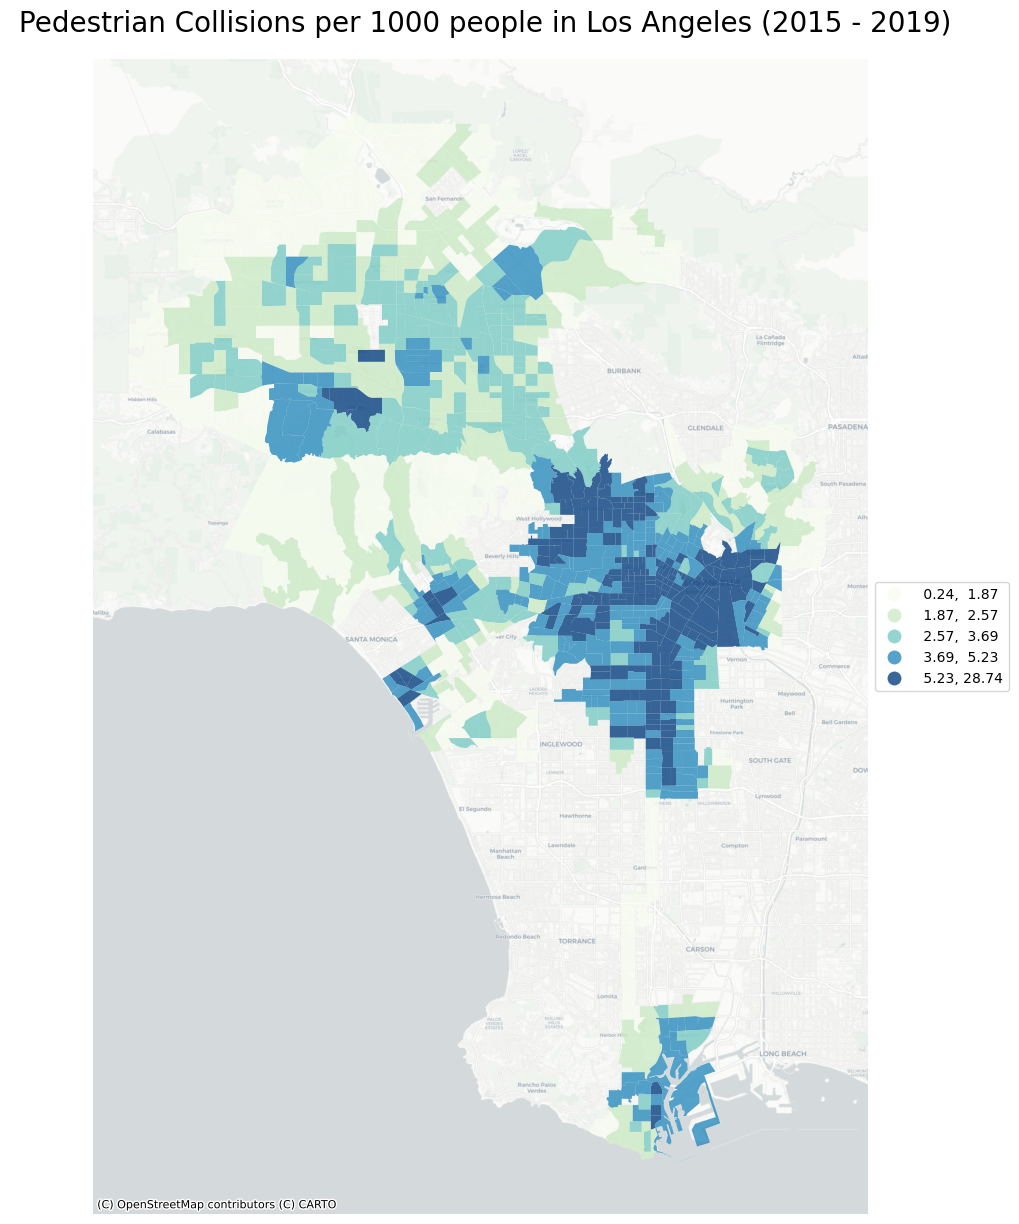

In [46]:
# spatial lag map - mapping the entire dataframe
fig, ax = plt.subplots(figsize=(15, 15))

la_city.plot(ax=ax,
         figsize=(15,15),
         column='collision_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='GnBu',
         scheme='quantiles', 
         legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})

ax.axis('off')
ax.set_title(' Pedestrian Collisions per 1000 people in Los Angeles (2015 - 2019)',fontsize=20,pad=20)

ctx.add_basemap(ax,zoom =12, source=ctx.providers.CartoDB.Positron)

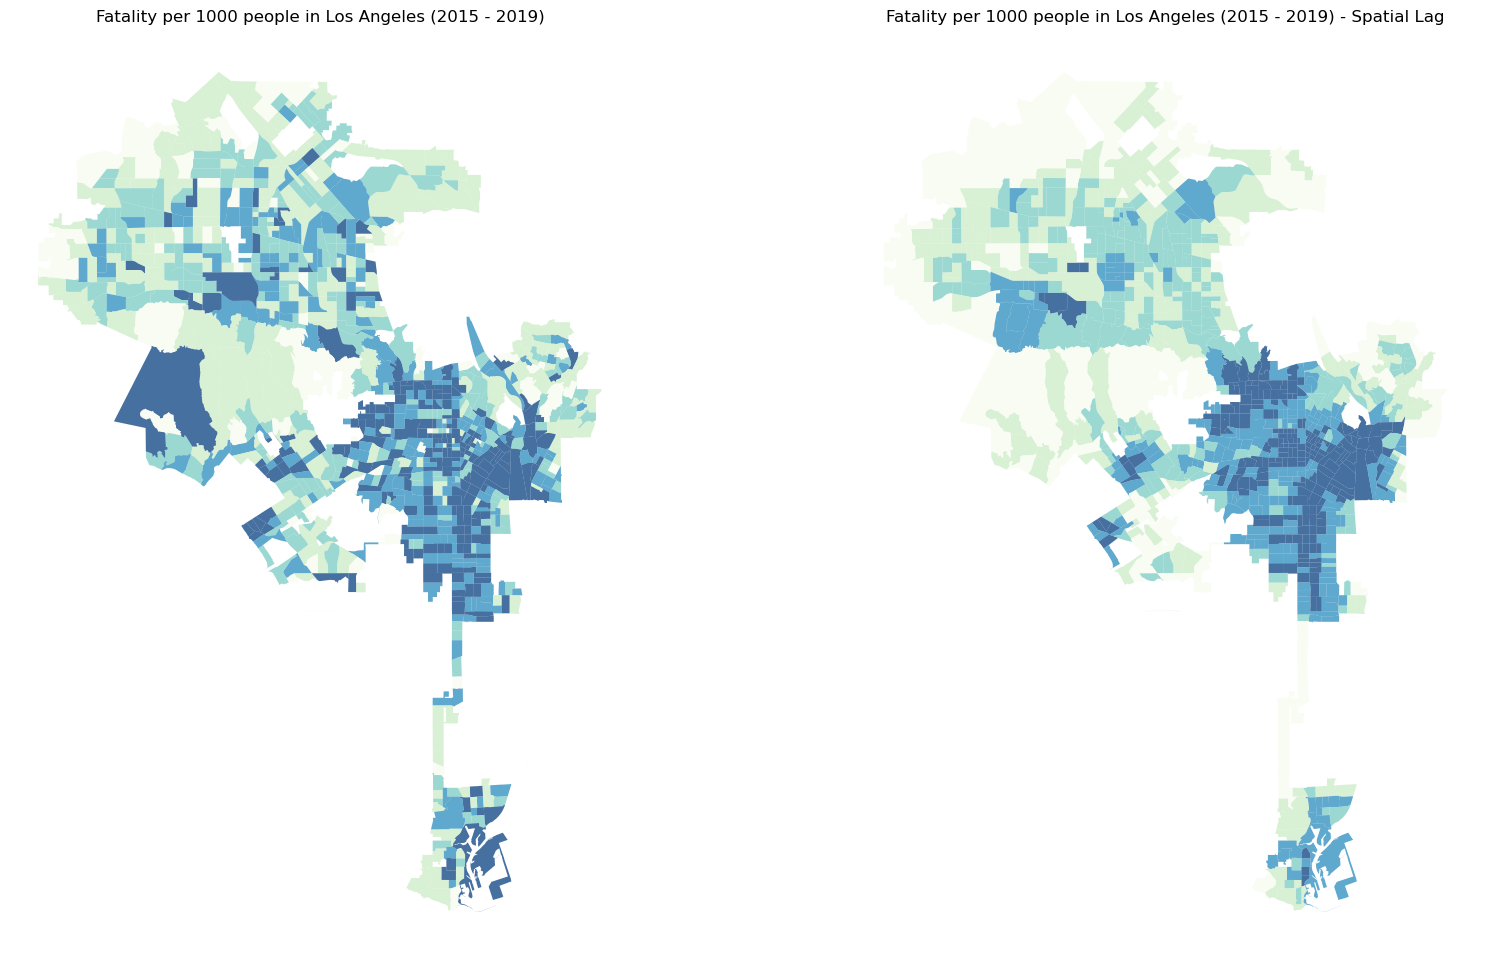

In [47]:
# ploting both collisions per 1000 and lag 
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

#ax[0] - map on the left 
la_city.plot(ax=ax[0], # this assigns the map to the left subplot
         column='collision_per_1000', 
         cmap='GnBu', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Fatality per 1000 people in Los Angeles (2015 - 2019)")

# ax[1] - map on the right 
la_city.plot(ax=ax[1], 
         column='collision_per_1000_lag', 
         cmap='GnBu', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Fatality per 1000 people in Los Angeles (2015 - 2019) - Spatial Lag")

plt.show()

In [48]:
# quantifying the degree of spatial correlation, output was positive meaning that high collision tracts are located near other high collision tracts and vise versa
y = la_city.collision_per_1000
moran = Moran(y, wq)
moran.I

np.float64(0.1962290153853872)

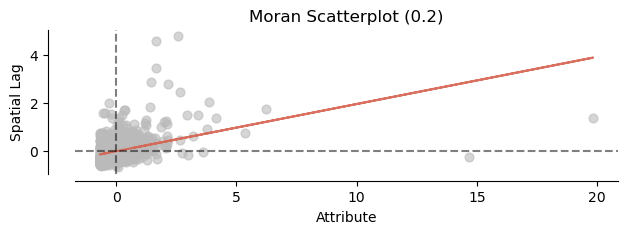

In [49]:
# creating scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.2', ylabel='Density'>)

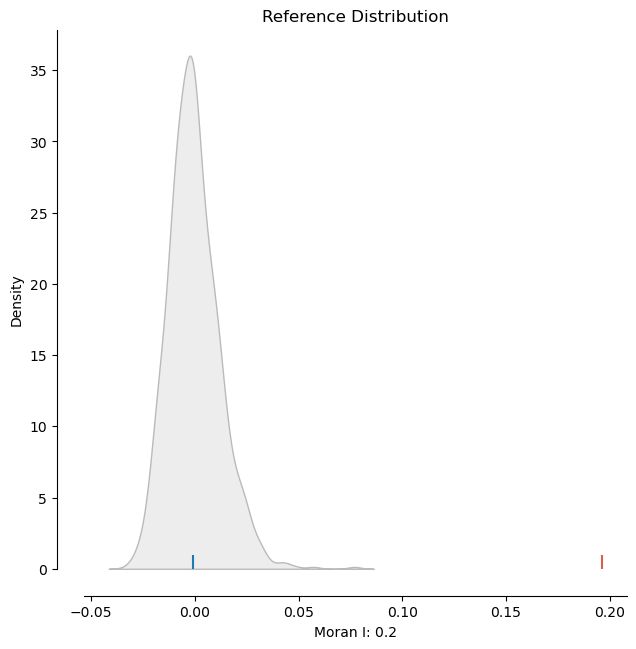

In [50]:
# dcreating reference distribution
plot_moran_simulation(moran,aspect_equal=False)

In [51]:
# p-value , 99% confidence, we are 99% confient that there is statistically significantly spatial clustering with pedestrian collisions per 1,000 residents in the City of LA from 2015-2019. 
moran.p_sim

np.float64(0.001)

In [52]:
# moran local scatterplot
lisa = esda.moran.Moran_Local(y, wq)

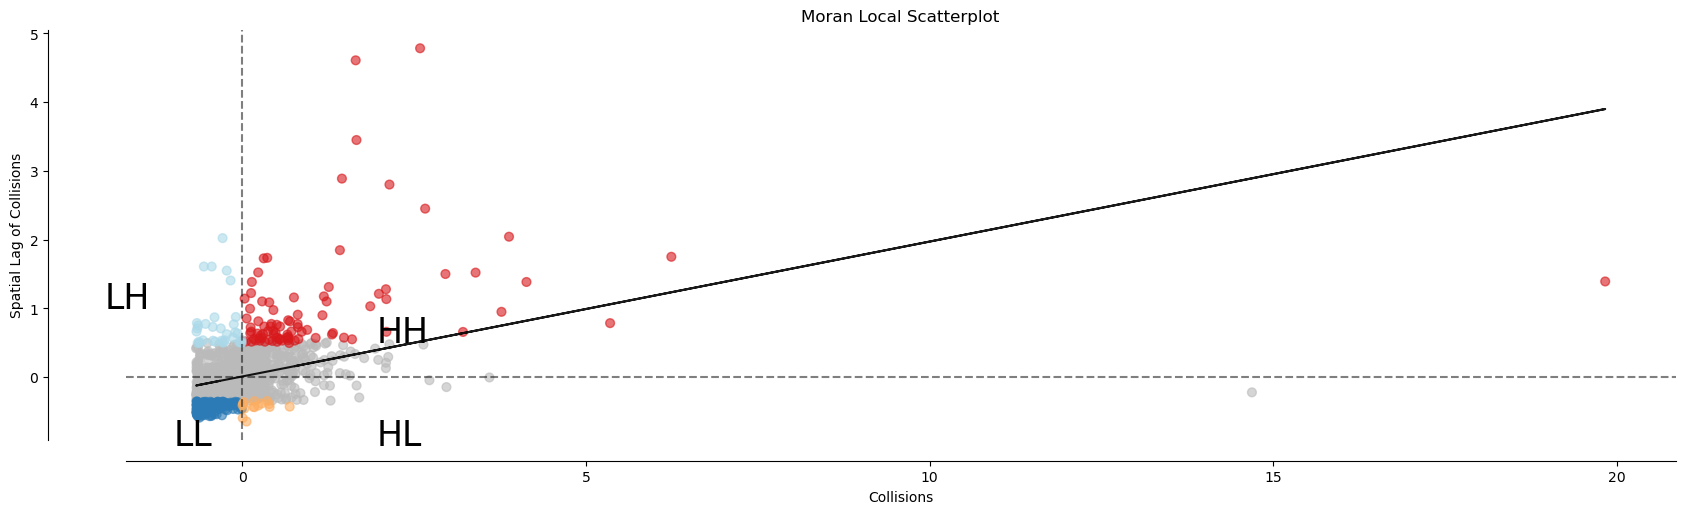

In [53]:
# plot 
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Collisions")
ax.set_ylabel('Spatial Lag of Collisions')

# test #1 
# nedd to play with the number more?
plt.text(1.95, 0.5, "HH", fontsize=25) 
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

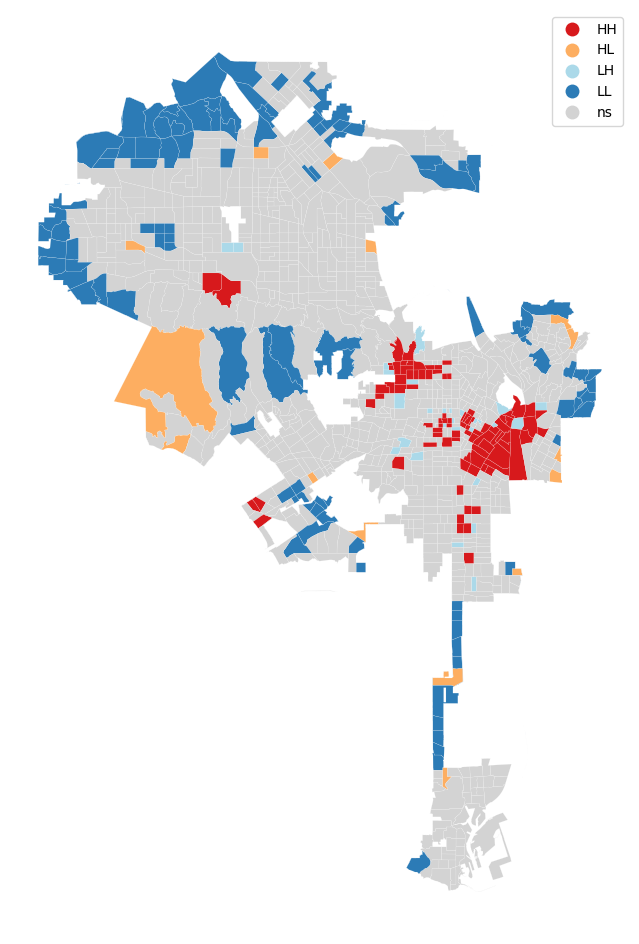

In [54]:
# mapping 
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, la_city, p=0.05, ax=ax) 
plt.show()

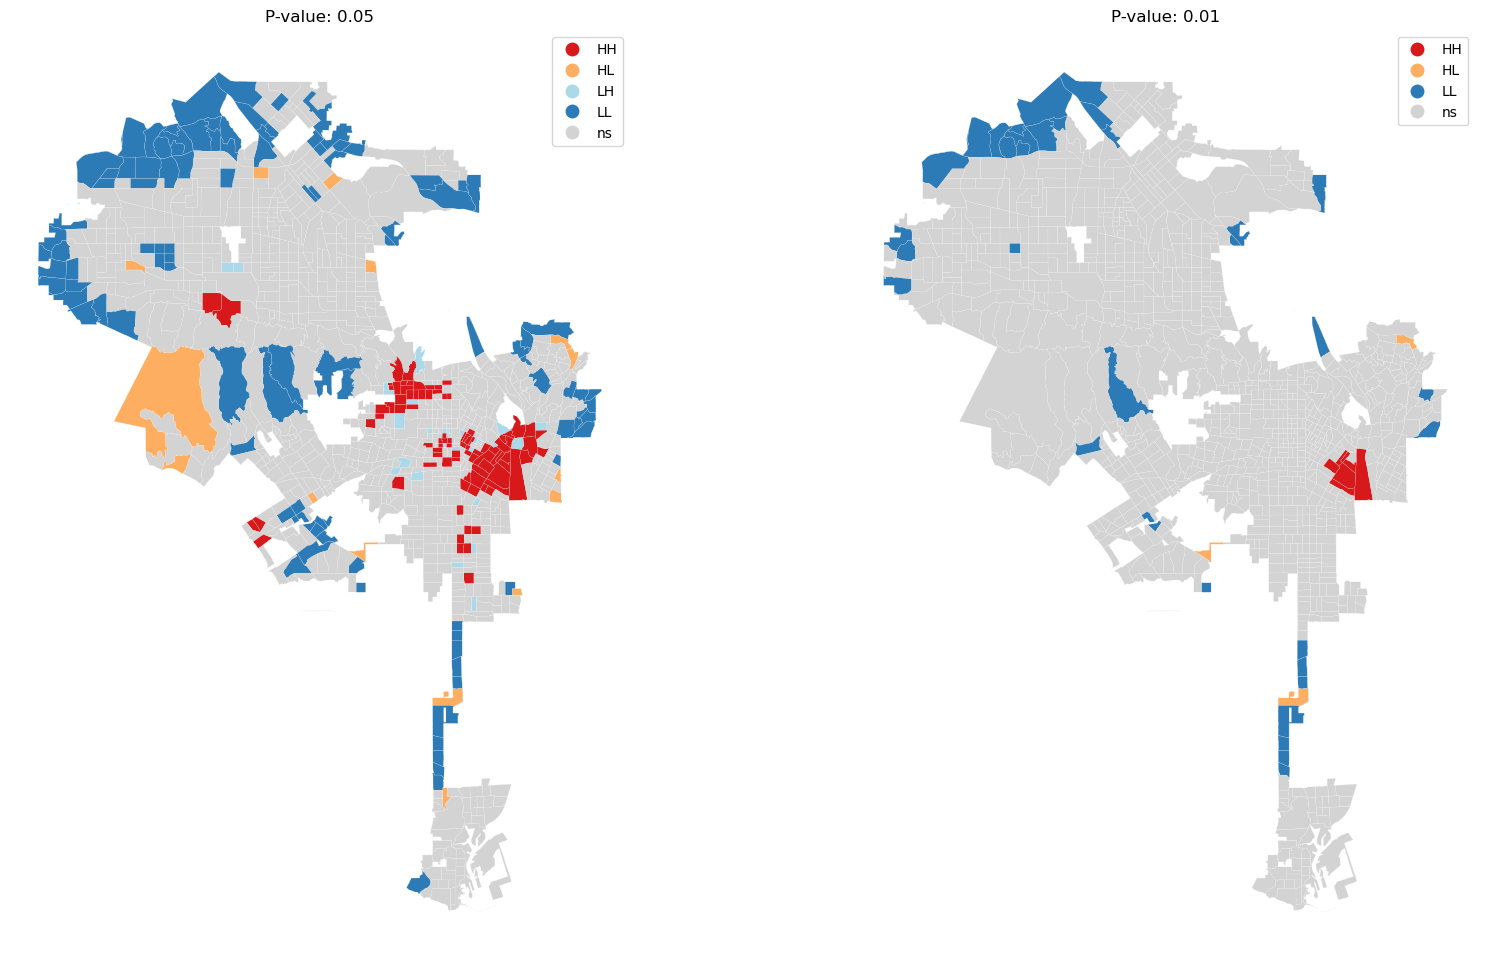

In [55]:
# create maps with different p-values
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa,la_city, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, la_city, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

## Team Roles

### Emily

Conducted spatial analysis for fatal pedestrian and bicycle collisions in the City of LA 

### Gema 

Conducted spatial analysis for pedestrian in the City of LA 

### Veronica 
Conducted spatial analysis for fatal bicycle collisions in the City of LA 